In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import matplotlib.ticker as mtick
from pathlib import Path

In [3]:
from sluis_hevelend import SluisHevelend

# Hevelend

In [4]:
outputdir = Path('Toepassing rekenmodel hevelend schutten')

In [5]:
alpha = 1
A = 9  # Doorstroomoppervlakte x coef van nivelleer mechaniek
A_hevelen = 3  # Doorstroomoppervlakte x coef van hevelende mechaniek
O_A = 2500
H = 10.85
T_l = 2*60
T_l_hevelen = 5*60

In [6]:
S = SluisHevelend(A_hevelen=A_hevelen, A=A, H=H, O_A=O_A, alpha=1, T_l=T_l, T_l_hevelen=T_l_hevelen)

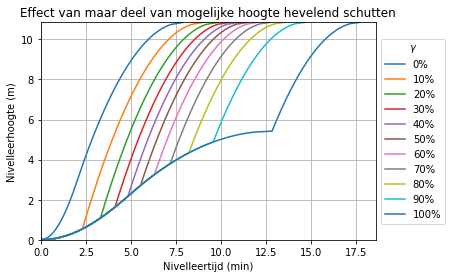

In [7]:
for aandeel_hevelend in np.linspace(0, 1, 11):
    S.gamma = aandeel_hevelend
    z, t = S.tijdserie()

    plt.plot(t / 60, z, label=f'{aandeel_hevelend:.0%}')
    
plt.grid()
plt.xlabel('Nivelleertijd (min)')
plt.ylabel('Nivelleerhoogte (m)')

plt.xlim(0, )
plt.ylim(0, H)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='$\gamma$')
plt.title('Effect van maar deel van mogelijke hoogte hevelend schutten')

plt.savefig(    outputdir / f'Deels hevelend schutten.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'Deels hevelend schutten.svg', bbox_inches='tight')

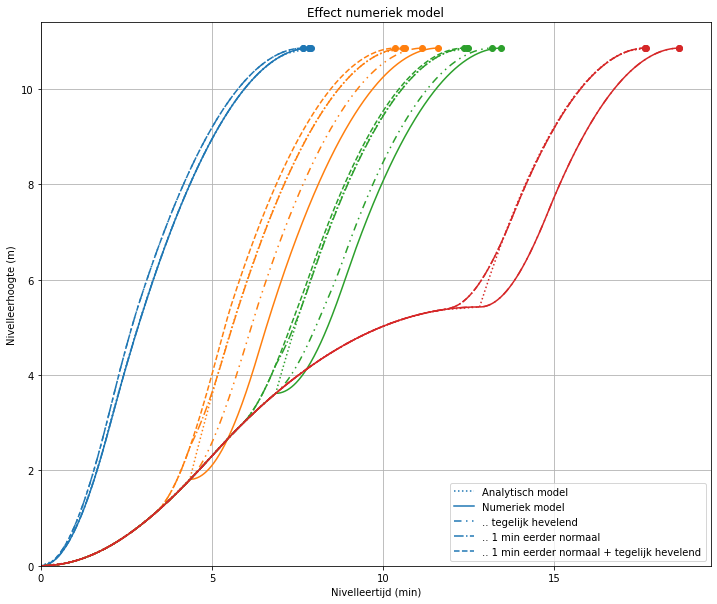

In [54]:
plt.subplots(figsize=(12, 10))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']


for ii, aandeel_hevelend in enumerate(np.linspace(0, 1, 4)):
    S.gamma = aandeel_hevelend
    delta_tijd_start_normaal = S.T_l/2

    z, t = S.tijdserie()
    plt.plot(t, z, label=f'{aandeel_hevelend:.0%}', color=colors[ii], ls=':')
    plt.scatter(t[-1], z[-1], color=colors[ii] )


    z_n, t_n = S.tijdseries_numeriek()
    plt.plot(t_n, z_n, label=f'{aandeel_hevelend:.0%}', color=colors[ii])
    plt.scatter(t_n[-1], z_n[-1], color=colors[ii] )
    
    
    z_n, t_n = S.tijdseries_numeriek(tijd_stop_hevelen=np.inf)
    plt.plot(t_n, z_n, label=f'{aandeel_hevelend:.0%}', color=colors[ii], ls=(0, (5, 3, 1, 3, 1, 3)))
    plt.scatter(t_n[-1], z_n[-1], color=colors[ii] )
    
    z_n, t_n = S.tijdseries_numeriek(tijd_start_normaal = S.tijd_hevelend- delta_tijd_start_normaal)
    plt.plot(t_n, z_n, label=f'{aandeel_hevelend:.0%}', color=colors[ii], ls='-.')
    plt.scatter(t_n[-1], z_n[-1], color=colors[ii] )
    
    
    z_n, t_n = S.tijdseries_numeriek(tijd_start_normaal = S.tijd_hevelend- delta_tijd_start_normaal, tijd_stop_hevelen=np.inf)
    plt.plot(t_n, z_n, label=f'{aandeel_hevelend:.0%}', color=colors[ii], ls='--')
    plt.scatter(t_n[-1], z_n[-1], color=colors[ii] )
    
    
plt.grid()
loc = plt.gca().get_xticks()
loc_new = np.arange(0, max(loc), 5*60)
labels_new = [f'{l/60:.0f}' for l in loc_new]
plt.xlim(0)
plt.ylim(0)
plt.xticks(loc_new, labels_new)
plt.xlabel('Nivelleertijd (min)')
plt.ylabel('Nivelleerhoogte (m)')
plt.title('Effect numeriek model')
plt.legend(['Analytisch model', 'Numeriek model', '.. tegelijk hevelend', f'.. {delta_tijd_start_normaal/60:.0f} min eerder normaal', f'.. {delta_tijd_start_normaal/60:.0f} min eerder normaal + tegelijk hevelend'])

plt.savefig(    outputdir / f'Verbeteringen numeriek model.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'Verbeteringen numeriek model.svg', bbox_inches='tight')

In [10]:
def addSecond_x_axes(ax1_ticks, ax2_ticks_labels, ax2_color='#888', ax2_label=None, ax1=None, position=40):
    '''
    Add a second xlabel below the current
    
    ax1_ticks: Locations on current xaxis where markers should be placed
    ax2_ticks_labels: Labels to put at these positions
    
    ax2_color: Color of all ax2 objects
    ax2_label: xlabel
    ax1: axes to apply function on. By default uses current axes
    
    return: ax2 handle
    '''
    
    if not ax1:
        ax1=plt.gca()
        
    assert all(ax1_ticks >= ax1.get_xlim()[0]) and all(ax1_ticks <= ax1.get_xlim()[1]), 'ax1_ticks larger than xlim. Ticks: {ticks}; Limits: {limits}'.format(ticks=ax1_ticks, limits=ax1.get_xlim())
   
    ax2 = ax1.twiny()

    ax2.xaxis.tick_bottom()
    ax2.xaxis.set_label_position('bottom') 
    ax2.spines['bottom'].set_position(('outward', position))
    ax2.spines['bottom'].set_color(ax2_color)
    ax2.tick_params(axis='x', colors=ax2_color)

    ax2.set_xlim(ax1.get_xlim())

    ax2.set_xticks(ax1_ticks, )
    ax2.set_xticklabels(ax2_ticks_labels)
    ax2.set_xlabel(ax2_label, color=ax2_color)
    return ax2


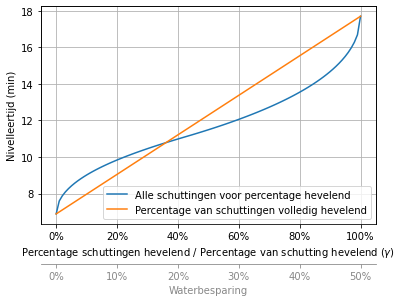

In [16]:
V_besparing_procentueel = {}
T_toename = {}

# S.T_l = 120
# S.T_l_hevelen = 300

for aandeel_hevelend in np.linspace(0, 1, 100):
    
    S.gamma = aandeel_hevelend
    
    V_besparing_procentueel[aandeel_hevelend] = S.volumeaandeel_waterbesparing
    T_toename[aandeel_hevelend] = S.tijd_totaal / 60
    
df = pd.Series(index=V_besparing_procentueel, data=T_toename,)
df.plot(label='Alle schuttingen voor percentage hevelend')

df.iloc[[0, -1]].plot(label='Percentage van schuttingen volledig hevelend')
plt.xlabel('Percentage schuttingen hevelend / Percentage van schutting hevelend ($\gamma$)')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.ylabel('Nivelleertijd (min)')
plt.grid()
plt.legend(loc='lower right')

ax1_ticks = np.linspace(0, 1, 6)
ax2_ticks = ax1_ticks / 2
ax2_labels = [f'{s:.0%}' for s in ax2_ticks]
addSecond_x_axes(ax1_ticks, ax2_labels, ax2_label='Waterbesparing')

plt.savefig(    outputdir / f'Percentage_schuttingen.png', bbox_inches='tight', dpi=150)
plt.savefig(    outputdir / f'Percentage_schuttingen.svg', bbox_inches='tight')

<AxesSubplot:>

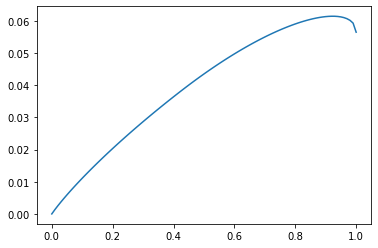

In [49]:
(df.index / df).plot()